In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ignite.metrics import Accuracy, Precision, Recall 

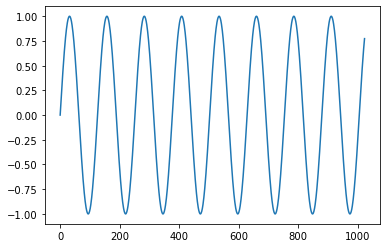

In [2]:
# creating a poly-tonal signal
h1 = 3
h2 = 7
h3 = 12

X = torch.arange(0, 1024, .05)
exp = torch.exp(X/-20)


#signal = torch.sin(h1*X) + torch.sin(h2*X) + torch.sin(h3*X)
#signal *= exp
signal = torch.sin(X)



plt.plot(signal[:1024])

In [3]:
def chunkize(series, chunk_size):
    n_chunks = len(series) - chunk_size
    chunked = []
    for i in range(n_chunks):
        chunk = series[i: i+chunk_size]
        data = chunk[:-1]
        target = chunk[-1]
        chunked.append([data, target])
    
    return chunked
        

In [4]:
chunksize = 128
chunked = chunkize(signal, chunksize)

In [5]:
class Signal(Dataset):
    
    def __init__(self, dataset, phase=None):
        
        if phase == 'train':
            start = 0
            end = int(len(dataset)*.5)
        if phase == 'val':
            start = int(len(dataset)*.5)
            end = int(len(dataset)*.75)
        if phase == 'test':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)
    
        self.dataset = dataset[start:end]


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.dataset[idx][0].unsqueeze(1)
        target = self.dataset[idx][1]
            
        return data, target

In [6]:
train_set = Signal(chunked, 'train')
val_set = Signal(chunked, 'val')
test_set = Signal(chunked, 'test')

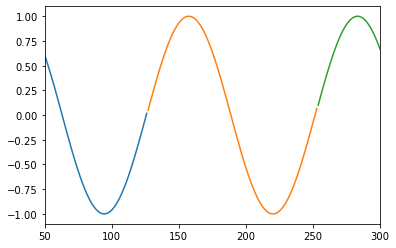

In [7]:
for idx, sample in enumerate(train_set.dataset):
    plt.plot(torch.arange(idx*len(sample[0]), idx*len(sample[0])+len(sample[0])), sample[0])
    plt.xlim(50, 300)

In [8]:
len(train_set)

20352

In [9]:
# hyperparams
batch_size = 128
learning_rate = 0.1
num_epochs = 50

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [11]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 1)

        # self.bn1 = nn.BatchNorm1d(num_features=hidden_size // 2)
        # self.bn2 = nn.BatchNorm1d(num_features=hidden_size // 2)
    
    def forward(self,x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [12]:
model = LSTM1(1, 128, 1)

In [13]:
if torch.cuda.is_available:
    device = 'cuda'
else:
    device = 'cpu'

model.to(device)

LSTM1(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
model(torch.rand(2, 4, 1).to(device))

tensor([[0.0818],
        [0.0815]], device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.MSELoss()

In [16]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []

for epoch in range(num_epochs):


    model.train()
    epoch_progress = tqdm(total=len(train_loader), desc=f'Epoch {epoch}', leave=False)
    for data, target in train_loader:

        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = torch.squeeze(model(data))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
    epoch_progress.close()
    
    model.eval()
    val_progress = tqdm(total=len(val_loader), desc=f'Epoch {epoch}. Validating...', leave=False)
    val_losses = []
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = torch.squeeze(model(data))
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
        val_progress.update()
    val_progress.close()    
        
    mean_val_loss = torch.mean(torch.tensor(val_losses))
    epoch_losses.append(mean_val_loss)

    if mean_val_loss == min(epoch_losses):
        torch.save(model, 'min_loss.pt')
        
    scheduler.step(mean_val_loss)
    
    if epoch % 10 == 0:
        print(f"Val loss {epoch}: {epoch_losses[-1]}")

    total_progress.update()

total_progress.close()

Val loss 0: 0.008582621812820435


Val loss 10: 0.00022800193983130157


Val loss 20: 2.406891326245386e-05


Val loss 30: 2.2389560399460606e-05


Val loss 40: 2.0959425455657765e-05


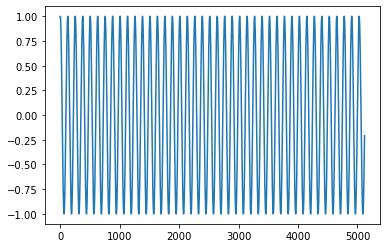

In [17]:
test_signal = signal[int(len(signal)*.75):]
plt.plot(test_signal)

In [18]:
model(torch.rand(1, 16, 1).to(device))

tensor([[0.7178]], device='cuda:0', grad_fn=<AddmmBackward>)

In [21]:
initial_data = test_signal[:chunksize-1].tolist()


def prepare(data):
    return torch.tensor(data).reshape(1, -1, 1).to(device)

preds = []
for _ in range(1000):
    pred = model(prepare(initial_data)).squeeze().tolist()
    preds.append(pred)
    initial_data.append(pred)
    initial_data.pop(0)

model(prepare(initial_data)).item()

0.8231590390205383

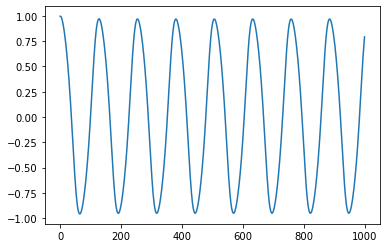

In [22]:
plt.plot(preds)